In [10]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from tavily import TavilyClient
from IPython.display import display, HTML

In [11]:
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["YOUTUBE_API_KEY"]=os.getenv("YOUTUBE_API_KEY")

In [12]:
#State class:
class State(TypedDict):
    dtc_code: str
    results: List[Dict]
    youtube_results: List[Dict] 
    formatted_report: str

In [13]:
#Node 1 : performs Tavily web search(top 3 results)

def tavily_search_node(state: State)-> State:
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    query = f"{state['dtc_code']} vehicle diagnostic trouble code causes solutions"
    response = tavily_client.search(query=query,max_results=3, search_depth="advanced")
    results = response.get('results', [])
    #print(f"Found {len(results)} results.")
    return {**state, "results": results}

In [14]:
#Node 2 : perform Youtube search (top 4 results)

import requests

def youtube_search_node(state: State) -> State:
    
    YOUTUBE_API_KEY = os.getenv("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("YouTube API key not found in environment variables.")
    
    search_query = f"{state['dtc_code']} diagnostic trouble code repair"
    url = "https://www.googleapis.com/youtube/v3/search"
    
    params = {
        "part": "snippet",
        "q": search_query,
        "key": YOUTUBE_API_KEY,
        "maxResults": 4,
        "type": "video"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"YouTube API error: {response.status_code} {response.text}")
    
    data = response.json()
    videos = []

    for item in data.get("items", []):
        video_id = item["id"]["videoId"]
        videos.append({
            "url": f"https://www.youtube.com/watch?v={video_id}",
            "video_id": video_id,
            "thumbnail_hq": item["snippet"]["thumbnails"].get("high", {}).get("url", ""),
            "thumbnail_max": f"https://img.youtube.com/vi/{video_id}/maxresdefault.jpg"
        })

    #print(f"✅ Found {len(videos)} YouTube videos.")
    return {**state, "youtube_results": videos}


In [15]:
def formatting_node(state: State) -> State:
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Combine Tavily content
    combined_text = "\n\n".join(r.get("content", "") for r in state["results"])
    source_urls = [r.get("url", "") for r in state["results"]]

    # Prepare YouTube video list
    youtube_results = state.get("youtube_results", [])

    # === PROMPT TO LLM ===
    prompt = f"""
You are an expert automotive diagnostic technician. Analyze the following diagnostic trouble code (DTC): {state['dtc_code']}

Web Research Content:
{combined_text}

Provide a concise and well-structured diagnostic report in this format:

Category: <brief one-line category of the issue>

Potential Causes:
- cause 1
- cause 2
- ...
(up to 8)

Possible Solutions:
- solution 1
- solution 2
- ...
(up to 8)
"""
    # Run the prompt
    response = llm.invoke([SystemMessage(content=prompt)])
    base_report = response.content.strip()

    # === APPEND FORMATTED LINKS (Web first, YouTube second) ===

    # Web URLs section
    urls_section = "\n\n🕸️ Web Sources:\n"
    for url in source_urls:
        urls_section += f"- {url}\n"

    # YouTube section with thumbnails
    youtube_section = "\n\n📺 YouTube Diagnostic Videos:\n"
    if youtube_results:
        # HTML grid
        grid_html = '<div style="display: flex; gap: 10px;">'
        for video in youtube_results:
            grid_html += f'''
                <div style="text-align:center;">
                    <a href="{video['url']}" target="_blank">
                        <img src="{video['thumbnail_hq']}" alt="Video" width="200" style="border: 1px solid #ccc; border-radius: 6px;">
                    </a>
                </div>
            '''
        grid_html += '</div>'
    else:
        grid_html = "No videos found."

    # === Assemble final report (text + rendered grid) ===
    final_text_report = (
        
        f"{base_report}\n"
        f"{urls_section}\n"
        f"{youtube_section}"
    )

    # Display final text report
    #print(final_text_report)

    # Show thumbnails grid (Jupyter only)
    display(HTML(grid_html))

    return {**state, "formatted_report": final_text_report}


In [16]:
# building the graph
builder = StateGraph(State)

#nodes:
builder.add_node("tavily_search",tavily_search_node)
builder.add_node("youtube_search", youtube_search_node)
builder.add_node("format_results", formatting_node)

#edges:
builder.add_edge(START,"tavily_search")
builder.add_edge("tavily_search", "youtube_search")
builder.add_edge("youtube_search","format_results")
builder.add_edge("format_results", END)

graph = builder.compile()

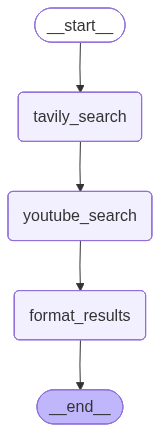

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
if __name__ == "__main__":
    dtc_code = input("Enter DTC/P code: ").strip().upper() # e.g. P0301
    initial_state = {
        "dtc_code": dtc_code, 
        "results": [], 
        "youtube_results": [],  # Added YouTube results field
        "formatted_report": ""
    }
    print(f"\n🔧 Starting diagnostic analysis for: {dtc_code}")
    print("-" * 60)

    
    final_state = graph.invoke(initial_state)

    print("\n" + "=" * 60)
    print("VEHICLE DIAGNOSTIC RESULTS")
    print("=" * 60)
    print(final_state["formatted_report"])
    # This displays the thumbnail grid under the correct heading
    

    


🔧 Starting diagnostic analysis for: P0301
------------------------------------------------------------



VEHICLE DIAGNOSTIC RESULTS
**Category:** Cylinder 1 Misfire Detected (P0301)

**Potential Causes:**
- Faulty spark plug or spark plug wire
- Faulty ignition coil or coil pack
- Faulty fuel injector for cylinder 1
- Low fuel pressure or poor fuel quality
- Faulty camshaft or crankshaft sensor
- Burned exhaust valve
- Poor engine compression in cylinder 1
- Defective engine control module (PCM)

**Possible Solutions:**
- Inspect and replace faulty spark plugs or wires
- Test and replace the ignition coil or coil pack if necessary
- Clean or replace the fuel injector for cylinder 1
- Check fuel pressure and ensure proper fuel quality
- Diagnose and replace faulty camshaft or crankshaft sensors
- Perform a compression test and address any issues with the exhaust valve
- Inspect the PCM for faults and reprogram or replace if needed
- Clear the DTC and monitor for reoccurrence after repairs


🕸️ Web Sources:
- https://www.hotshotsecret.com/diagnose/trouble-codes/p0301-code/
- https://www.au